In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import zipfile
import PIL.Image
import json
import matplotlib.pyplot as plt
import dnnlib
import pickle
#from training.optim import OptimEDM
import tqdm
try:
    import pyspng
except ImportError:
    pyspng = None
import torch.nn.init as init

### Some basic helper functions

In [ ]:
def load_img_zip(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    all_names = set(zip_file.namelist())

    PIL.Image.init()
    image_names = sorted(fname for fname in all_names if file_ext(fname) in PIL.Image.EXTENSION)

    images = []    
    # load images
    for name in image_names:
        with zip_file.open(name, 'r') as f:
            if pyspng is not None and file_ext(name) == '.png':
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis]  # HW => HWC
        image = image.transpose(2, 0, 1)     # HWC => CHW

        # append images
        images.append(image[np.newaxis, :, :, :])

    images = np.concatenate(images, axis=0)
    N, C, H, W = images.shape
    y = torch.from_numpy(images).to(torch.float32) / 127.5 - 1
    y = y.reshape(N, C*H*W)
    return y

def normalize_img(img):
    img = img-torch.min(img)
    img = img/torch.max(img)
    return img

def torch_to_np(img):
    img = img.detach().cpu()[0].permute(1,2,0).numpy()
    return img

def normalize_img_np(img):
    img = img-np.min(img)
    img = img/np.max(img)
    return img

def get_denoised_img(noisy_img, net, var, device=torch.device('cuda')):
    # variance should be in the range(0.002,80)
    return net(noisy_img, torch.tensor(var,device=device))

def get_dataloader(data_path, batch_size):
    c = dnnlib.EasyDict()
    c.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path=data_path, use_labels=False, xflip=False, cache=True)
    c.data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=1, prefetch_factor=2)
    dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs) # subclass of training.dataset.Dataset
    dataloader = torch.utils.data.DataLoader(dataset=dataset_obj, batch_size=batch_size, shuffle=False)
    return dataset_obj

def custom_sort(string):
    return float(string)

def file_ext(fname):
    return os.path.splitext(fname)[1].lower()

### Define the optimal denoiser for the empirical multi-delta distribution

In [15]:
class OptimEDM(nn.Module):
    """
    This class implements the ideal EDM to approximate the denoised function with acceleration
    """
    def __init__(self, 
                 data_path,
                 label_dim = 0,
                 sigma_min = 0,
                 ref_size = None,
                 sigma_max = float('inf'), 
                 device=torch.device('cuda')):
        super().__init__()
        self.data_path = data_path
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.device = device
        # load images and labels
        assert data_path.endswith('.zip') or data_path.endswith('.npz')
        if data_path.endswith('.npz'):
            self.data = np.load(data_path)
            self.images, self.labels = self.data['images'], self.data['labels']
        elif data_path.endswith('.zip'):
            if data_path == 'datasets/cifar10-32x32.zip':
                self.images, self.labels = load_cifar10_zip(zip_path=data_path)
            #elif data_path == 'datasets/ffhq-64x64.zip':
            else:
                print('load ffhq')
                #print('haha')
                self.images, self.labels = load_ffhq_zip(zip_path=data_path)

        self.img_resolution = self.images.shape[2]
        self.img_channels = self.images.shape[1]
        self.label_dim = label_dim

        N, C, H, W = self.images.shape

        # Transform to FloatTensor        
        self.y = torch.from_numpy(self.images).to(torch.float32).to(self.device) / 127.5 - 1  # y shape: (N2, C, H, W)
        self.y = self.y.reshape(N, C*H*W)  # y shape: (N2, C*H*W)
        
        # Enable batch size sampling
        self.data_scale = self.y.shape[0]
        self.ref_size = ref_size
    
    def forward(self, x, sigma, class_labels=None, augment_labels=None):
        if self.ref_size is not None and self.ref_size < self.data_scale:
            random_index = torch.randperm(self.data_scale)[:self.ref_size]
            y = self.y[random_index]
        else:
            y = self.y
        B, C, H, W = x.shape
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1)
        x = x.reshape(B, C*H*W)
        # compute score function
        distance = - torch.cdist(x, y, p=2) ** 2 / 2 / sigma ** 2     # (B, N)
        prob = torch.softmax(distance, dim=1)                         # softmax in the axis of N, (B, N)
        denoised = prob @ y                                           # (B, C*H*W)
        denoised = denoised.reshape(B, C, H, W)
        # score = (denoised - x) / sigma ** 2                                                    
        return denoised
    
    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)


### Define the Multivaraite Gaussian denoiser and sampling method

In [7]:
# Gaussian model
class multi_gaussian(nn.Module):
    def __init__(self, mean, covariance,low_rank):
        super(multi_gaussian, self).__init__()
        self.mean = mean.to(torch.float64)
        self.U, self.S, self.Vh = covariance
        self.U = self.U[:,:low_rank].clone().to(torch.float64)
        self.S = self.S[:low_rank].clone().to(torch.float64)
        self.Vh = self.Vh[:low_rank,:].clone().to(torch.float64)
    def forward(self, x, sigma):
        S = self.S/(self.S + sigma**2)
        I = torch.eye(self.U.shape[0], device=self.U.device, dtype=self.U.dtype)
        x = x.flatten(start_dim = 1)
        out = torch.mm(self.Vh, (x - self.mean).t())
        out = torch.mm(torch.diag(S),out)
        return (self.mean + torch.mm(self.U, torch.mm(torch.diag(S), torch.mm(self.Vh, (x - self.mean).t()))).t())

# This function is used to sample images from EDM model, we use the simple first order sampler.    
def generate_image(
    net, latents ,even_t=False, num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, device=torch.device('cuda')):
    sigma_list = []
    intermediates = []
    denoised_intermediates = []
    
    # Pick latents and labels.
    batch_size = latents.shape[0]
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    if even_t == True:
        t_steps = torch.from_numpy(np.linspace(sigma_max, sigma_min, num_steps)).to(device)
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        '''
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        '''
        intermediates.append(x_cur.detach().cpu())
        denoised_intermediates.append(denoised.detach().cpu())
        sigma_list.append(t_cur.item())
        
    # Save image grid.
    return sigma_list, intermediates, denoised_intermediates

# This function is used to sample images from Gaussian model, we use the simple first order sampler.    
def generate_image_Gaussian(
    net, Gaussian_net, latents ,even_t=False, num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, device=torch.device('cuda')):
    sigma_list = []
    intermediates = []
    denoised_intermediates = []
    
    # Pick latents and labels.
    batch_size = latents.shape[0]
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    if even_t == True:
        t_steps = torch.from_numpy(np.linspace(sigma_max, sigma_min, num_steps)).to(device)
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step.
        denoised = Gaussian_net(x_hat, t_hat).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        '''
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        '''
        intermediates.append(x_cur.detach().cpu())
        denoised_intermediates.append(denoised.detach().cpu())
        sigma_list.append(t_cur.item())
        
    # Save image grid.
    return sigma_list, intermediates, denoised_intermediates

### We first examine the FFHQ dataset

In [9]:
torch.manual_seed(0)

# Prepare test image and the noise
device = torch.device('cuda')
data_path_1 = 'datasets/ffhq-64x64.zip'

# Construct the EDM model
net_final_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-ffhq-64x64-uncond-ve.pkl'
with dnnlib.util.open_url(net_final_pkl) as f:
    net_final = pickle.load(f)['ema'].to(device)

# Construct the optimal denoiser for the emprical multi-delta distribution (can not generalize)
with dnnlib.util.open_url(data_path_1) as f:
    net_optimal = OptimEDM(data_path=data_path_1,device=device)  

# Construct the Gaussian model
imgs = load_img_zip(data_path_1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_FFHQ/70000/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model = multi_gaussian(mean, (U, S, Vh),3*64*64).to(device)

load ffhq


100%|██████████| 70000/70000 [00:03<00:00, 20435.98it/s]


In [11]:
# Sampling from the models
torch.manual_seed(100) 
latents = torch.randn(20,3,64,64).to(device)
num_steps = 10
sigma_list, intermediates_edm, denoised_intermediates_edm = generate_image(net_final, latents ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_optimal, denoised_intermediates_optimal = generate_image(net_optimal, latents ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian, denoised_intermediates_Gaussian = generate_image_Gaussian(net_final, Gaussian_model, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)

100%|██████████| 10/10 [00:01<00:00,  7.22step/s]


### Below demonstrates the sampling trajectories of vairous models. Notice that the EDM model generalizes, generating high quality, novel images. The optimal denoisers for the empirical distribution retrieves images that are in the trianing set. The Gaussian model generates samples that closely align with those generated from the EDM model, despite the perceptual quality is lower.

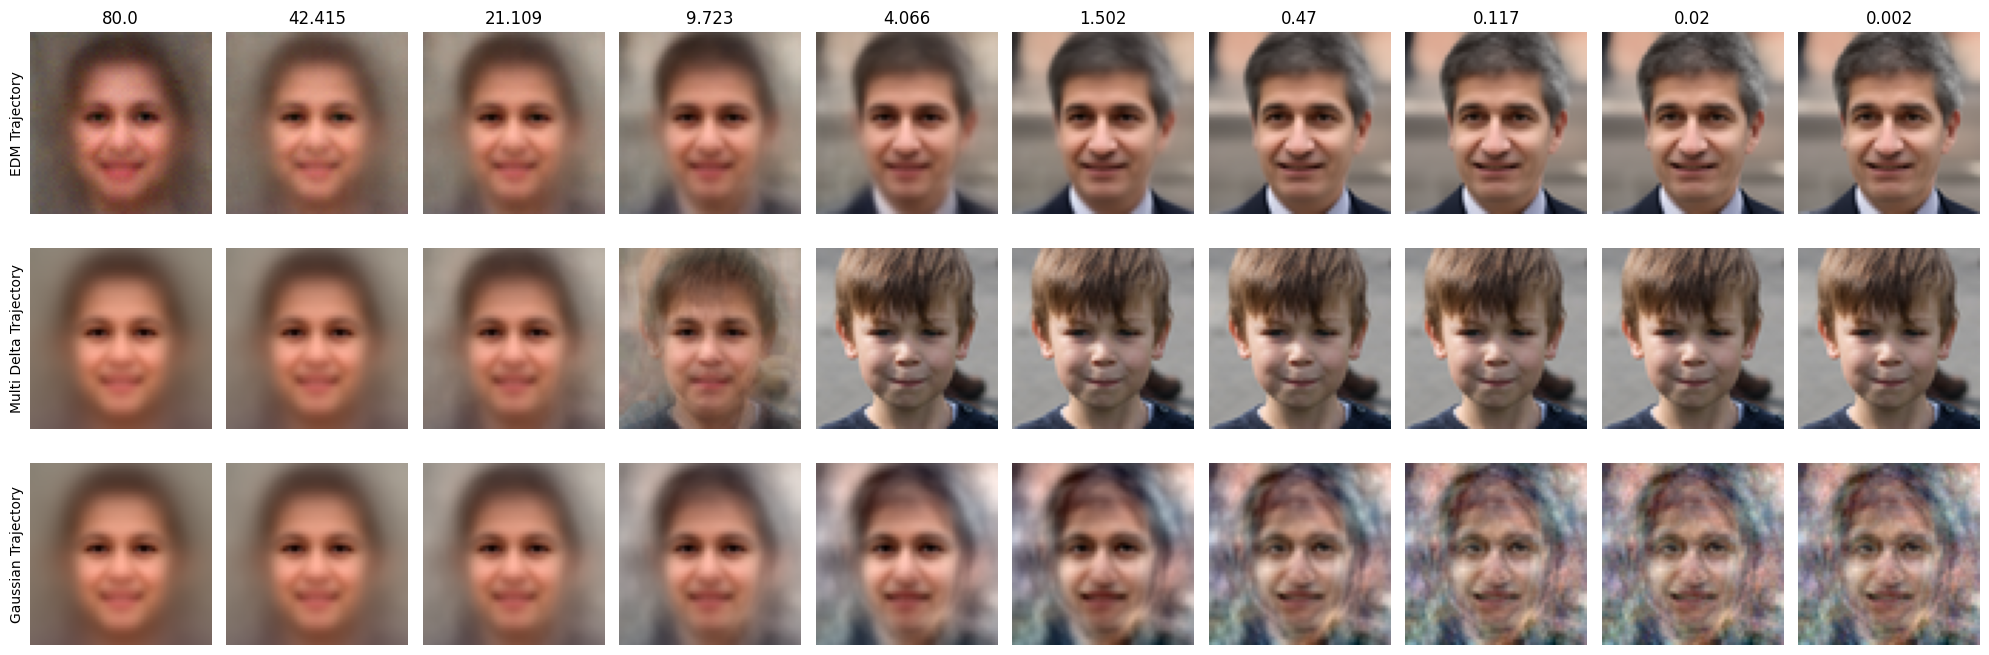

In [13]:
# Visualize the generation
idx = 6
plt.figure(figsize=(20,9))
plt.subplots_adjust(wspace=0,hspace=0)
for i in range(10):
    plt.subplot(4,10,i+1)
    plt.title(round(sigma_list[i],3))
    plt.imshow(normalize_img(denoised_intermediates_edm[i][idx].permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM Trajectory')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
for i in range(10):
    plt.subplot(4,10,i+1+10)
    #plt.title(round(sigma_list[i],3))
    plt.imshow(normalize_img(denoised_intermediates_optimal[i][idx].permute(1,2,0)))
    if i==0:
        plt.ylabel('Multi Delta Trajectory')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
for i in range(10):
    plt.subplot(4,10,i+1+20)
    #plt.title(round(sigma_list[i],3))
    plt.imshow(normalize_img(denoised_intermediates_Gaussian[i][idx].reshape(3,64,64).permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian Trajectory')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 

# Here we do not provide generations of the linear models since these models are quite large for storing and we want to make 
# this notebook as easy to use as possible. We will include instructions for constructing the linear models in a seperate notebook.
'''
for i in range(10):
    plt.subplot(4,10,i+1+30)
    #plt.title(round(sigma_list[i],3))
    plt.imshow(normalize_img(denoised_intermediates_linear[i][idx].reshape(3,64,64).permute(1,2,0)))
    if i==0:
        plt.ylabel('Linear Model Trajectory')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
'''
        
plt.tight_layout()
plt.show()

### Below we visualize more samples

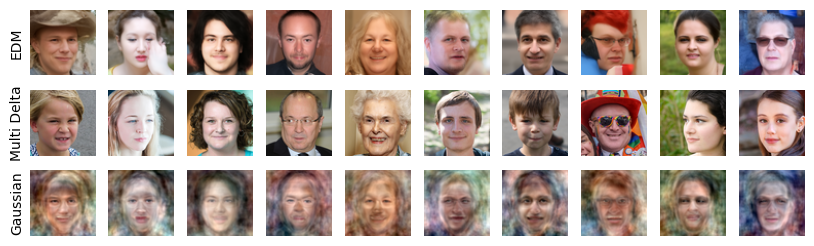

In [14]:
num_show = 10
plt.figure(figsize=(10,4))
for i in range(num_show):
    plt.subplot(4,num_show,i+1)
    plt.imshow(normalize_img(denoised_intermediates_edm[-1][i].permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
for i in range(num_show):
    plt.subplot(4,num_show,i+1+10)
    plt.imshow(normalize_img(denoised_intermediates_optimal[-1][i].permute(1,2,0)))
    if i==0:
        plt.ylabel('Multi Delta')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
for i in range(num_show):
    plt.subplot(4,num_show,i+1+20)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian[-4][i].reshape(3,64,64).permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
# for i in range(num_show):
#     plt.subplot(4,num_show,i+1+30)
#     plt.imshow(normalize_img(denoised_intermediates_linear[-4][i].reshape(3,64,64).permute(1,2,0)))
#     if i==0:
#         plt.ylabel('Linear')
#     plt.xticks([])
#     plt.yticks([])
#     for pos in ['right', 'top', 'bottom', 'left']: 
#         plt.gca().spines[pos].set_visible(False) 

### Next, we investigate the Cifar-10 dataset

In [48]:
torch.manual_seed(0)

# Prepare test image and the noise
device = torch.device('cuda')
data_path_1 = 'datasets/cifar10-32x32.zip'

# Construct the EDM model
net_final_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-ve.pkl'
with dnnlib.util.open_url(net_final_pkl) as f:
    net_final = pickle.load(f)['ema'].to(device)

# Construct the optimal denoiser for the emprical multi-delta distribution (can not generalize)
with dnnlib.util.open_url(data_path_1) as f:
    net_optimal = OptimEDM(data_path=data_path_1,device=device)  

# Construct the Gaussian model
imgs = load_img_zip(data_path_1)
mean = torch.mean(imgs, dim=0)
temp = imgs-mean
covariance = temp.T@temp/temp.shape[0]
covariance = covariance.to(device)
U,S,Vh = torch.linalg.svd(covariance, full_matrices=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
mean = mean.to(device)


# You can save those data for later use
'''
save_dir = 'Covariance_Cifar/50000/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
torch.save(mean, os.path.join(save_dir,'mean.pt'))
torch.save((U,S,Vh), os.path.join(save_dir,'covariance.pt'))
'''

Gaussian_model = multi_gaussian(mean, (U, S, Vh),3*32*32).to(device)

100%|██████████| 50000/50000 [00:01<00:00, 36235.66it/s]


In [49]:
# Sampling from the models
torch.manual_seed(0) 
latents = torch.randn(30,3,32,32).to(device)
num_steps = 10
sigma_list, intermediates_edm, denoised_intermediates_edm = generate_image(net_final, latents ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_optimal, denoised_intermediates_optimal = generate_image(net_optimal, latents ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)
sigma_list, intermediates_Gaussian, denoised_intermediates_Gaussian = generate_image_Gaussian(net_final, Gaussian_model, latents.reshape(-1,3*32*32) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)

100%|██████████| 10/10 [00:00<00:00, 473.59step/s]


Sample idx: 1


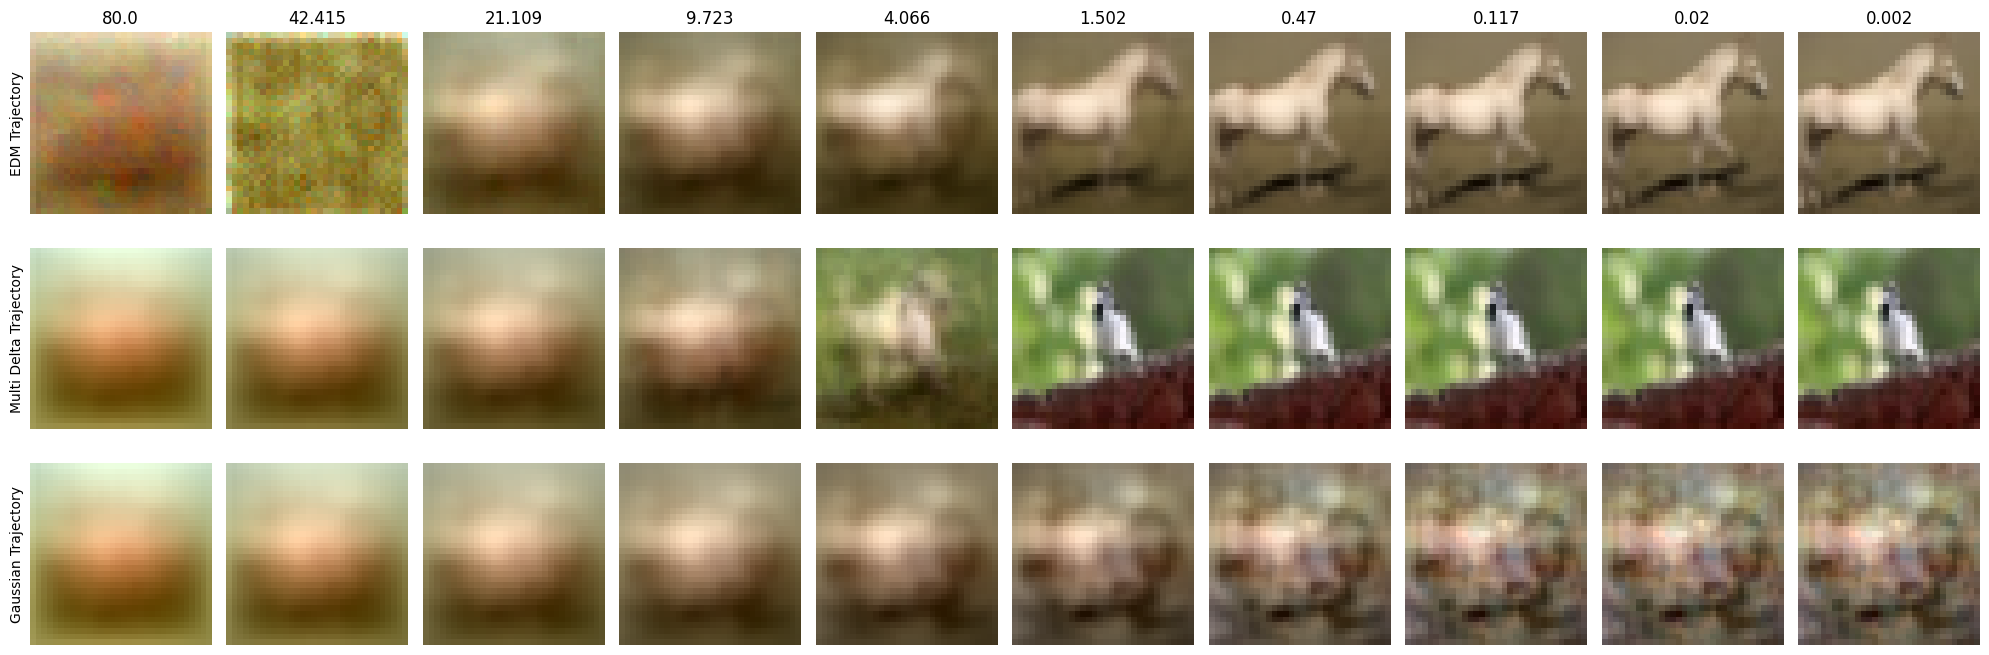

Sample idx: 2


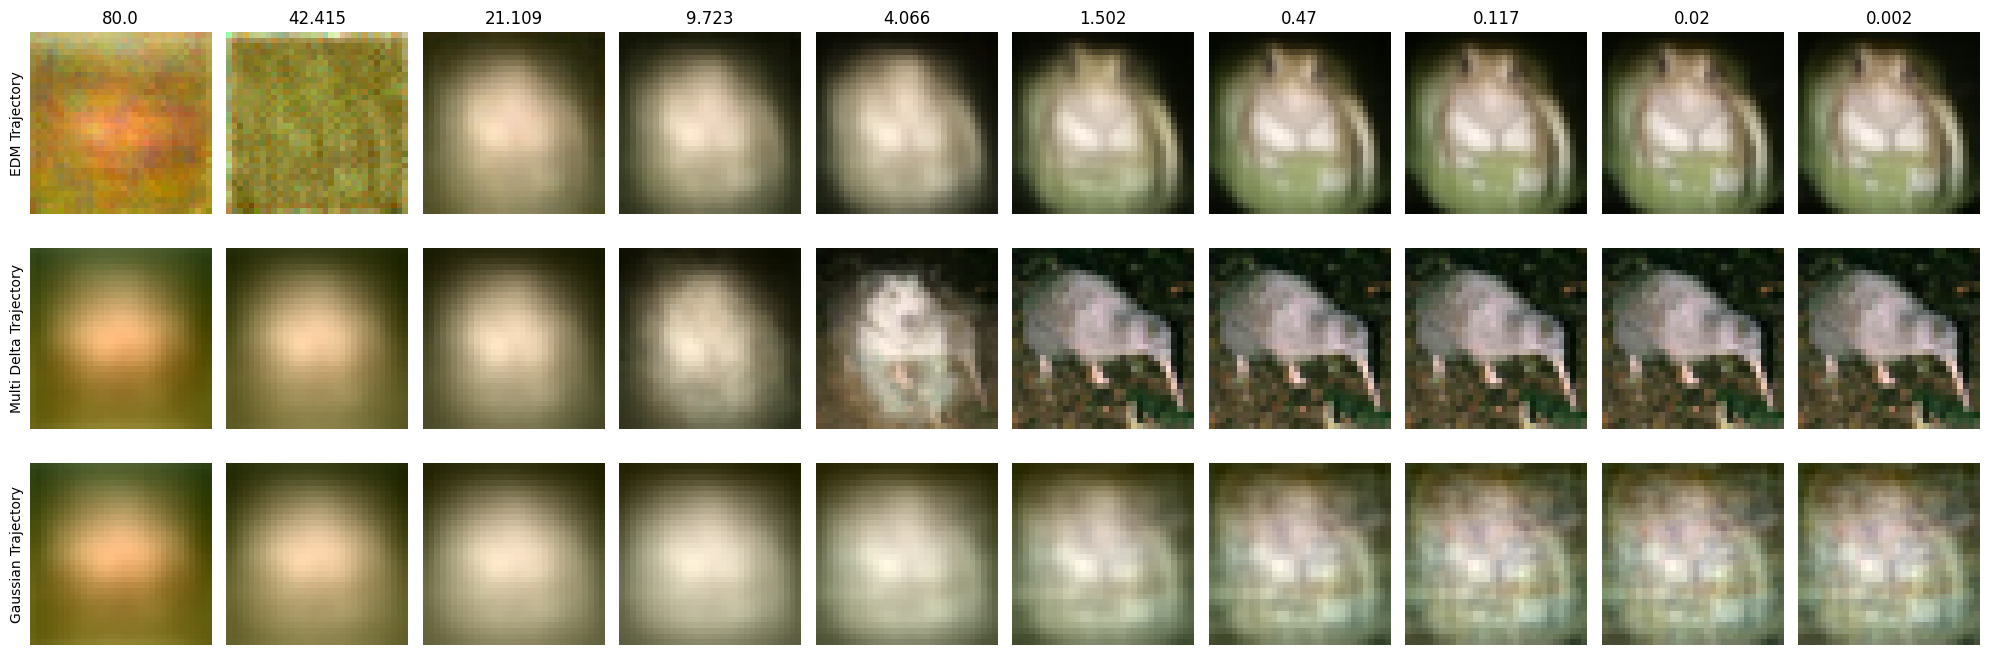

Sample idx: 3


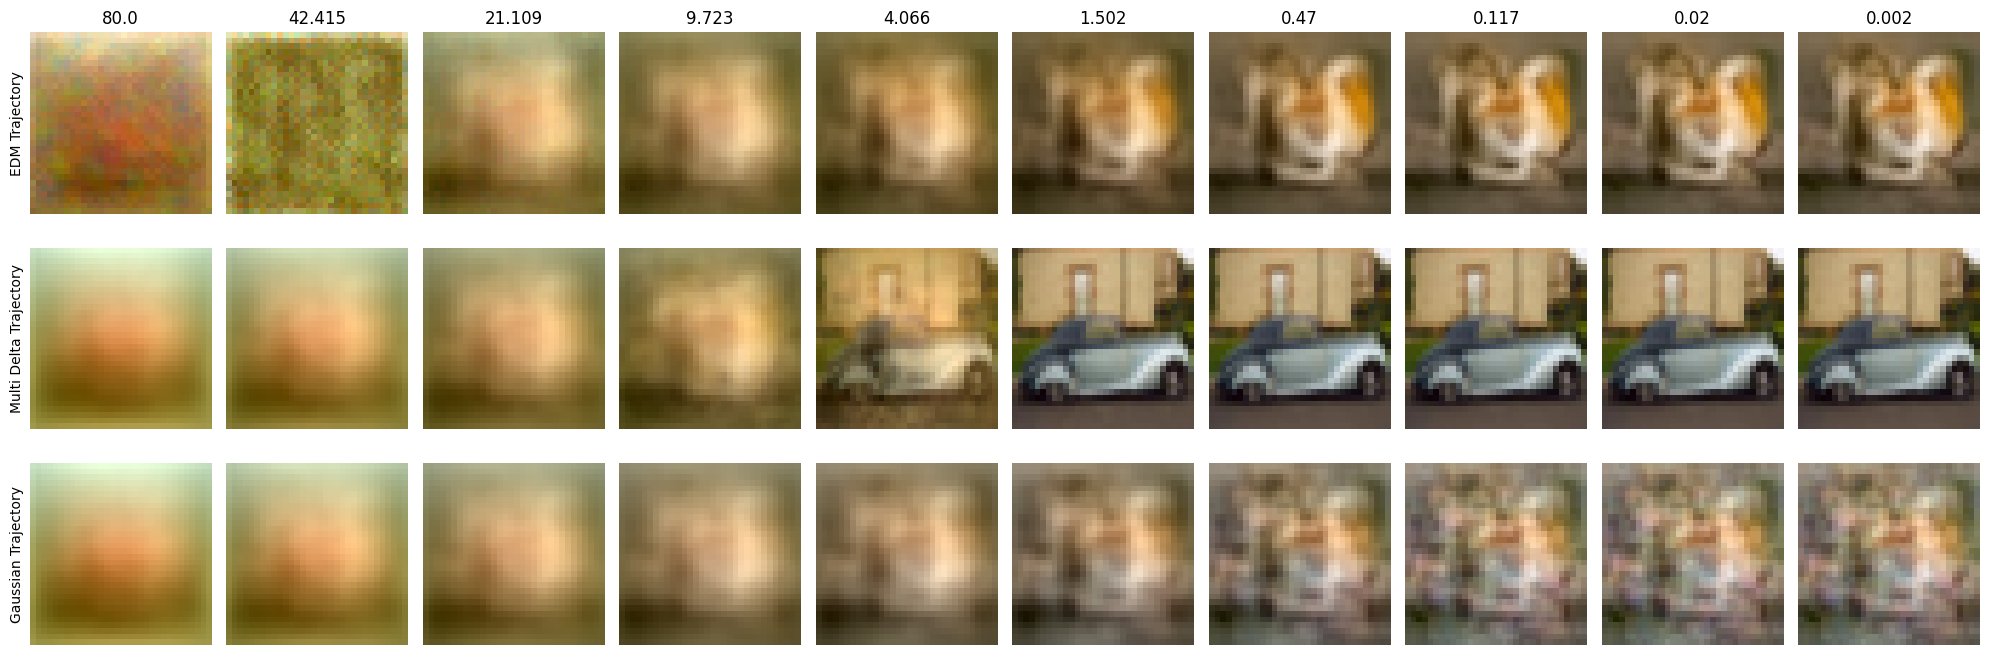

Sample idx: 4


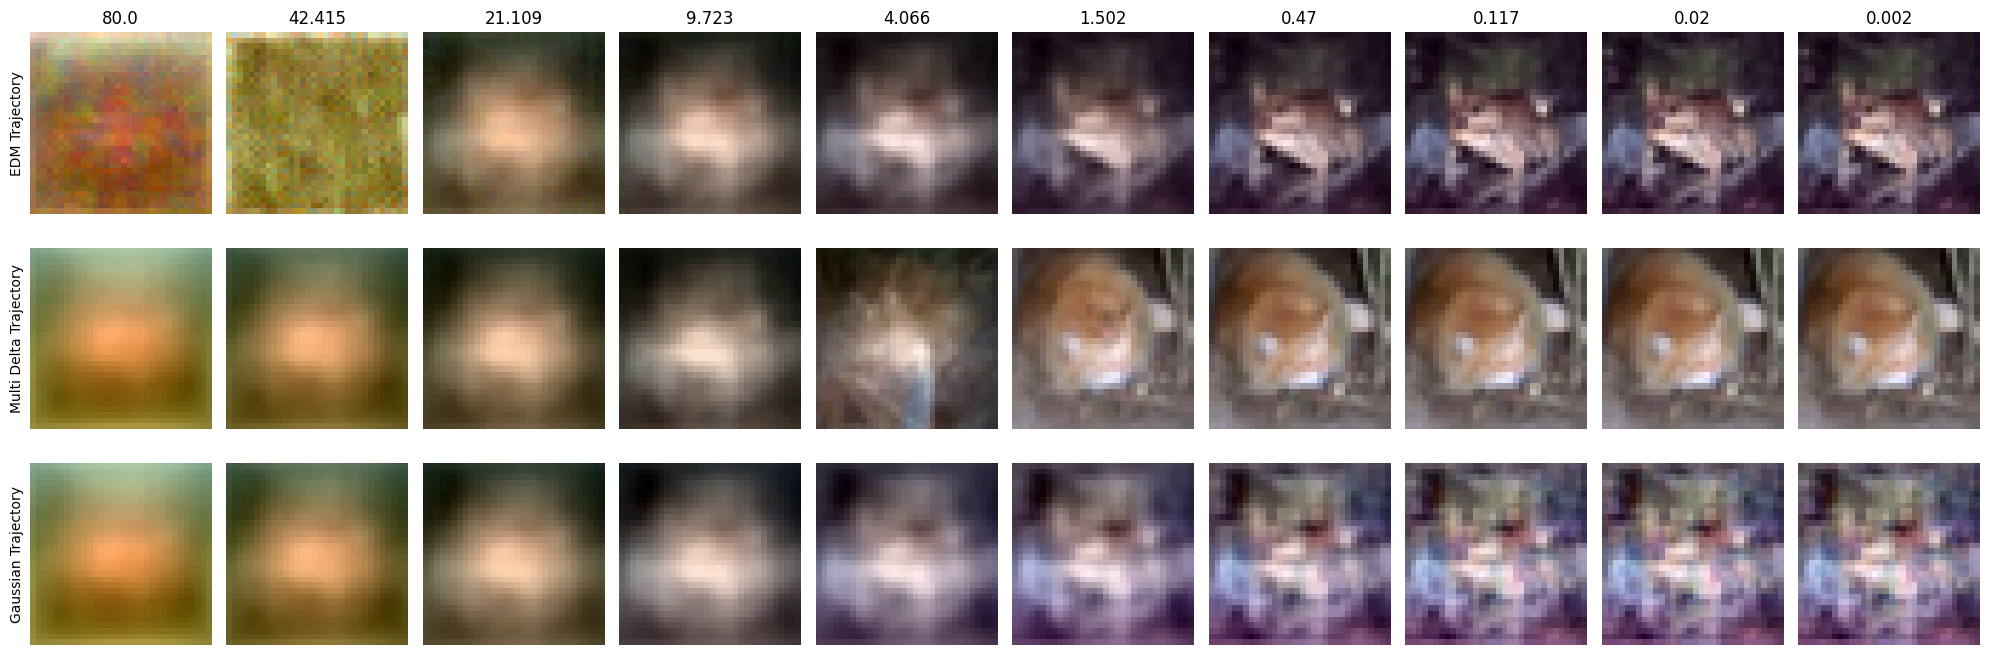

Sample idx: 5


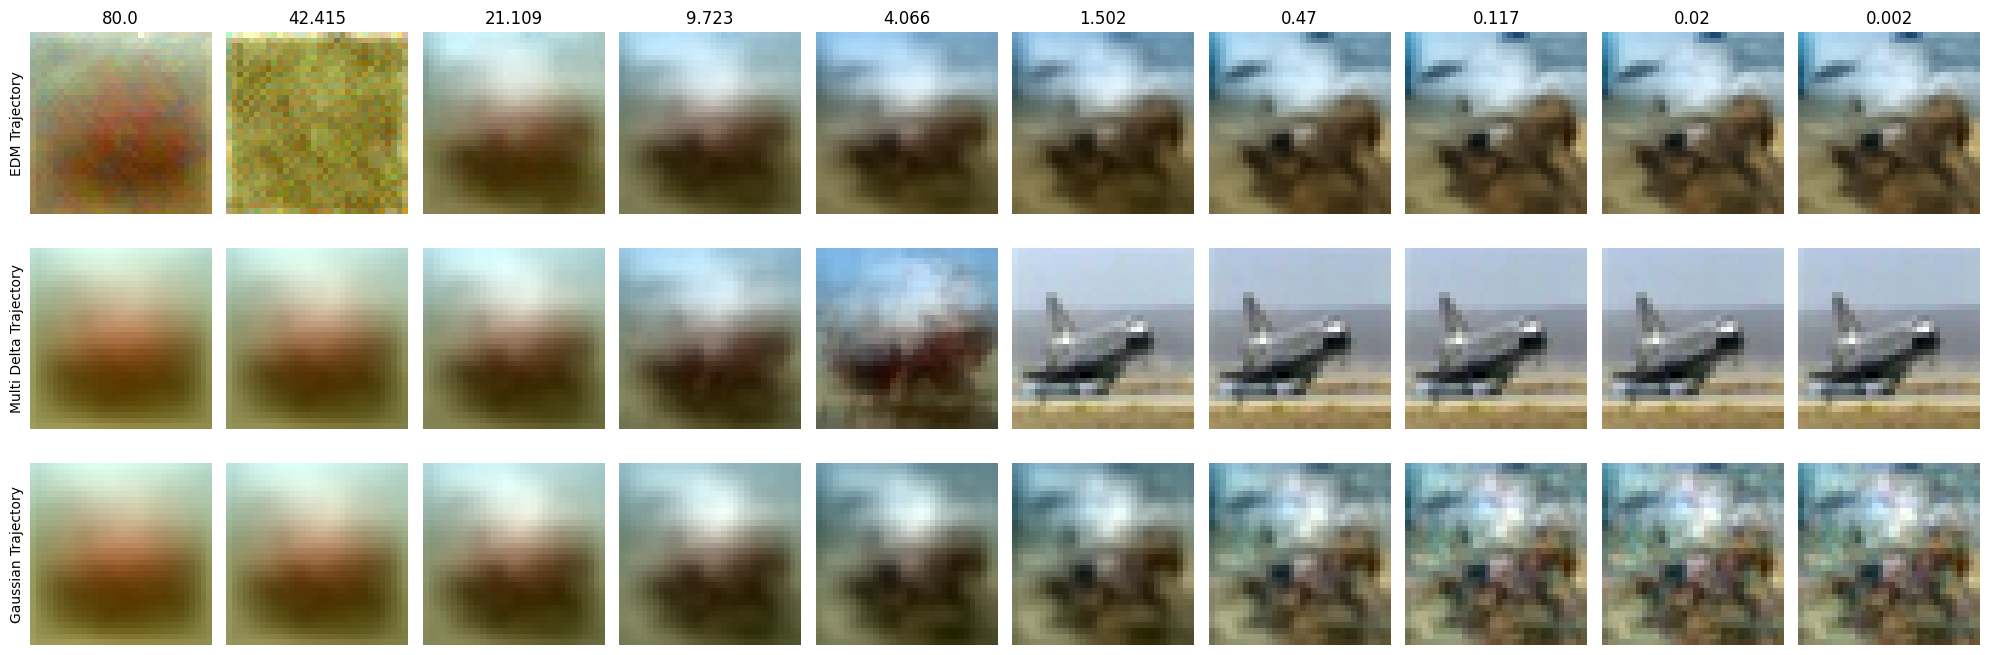

Sample idx: 6


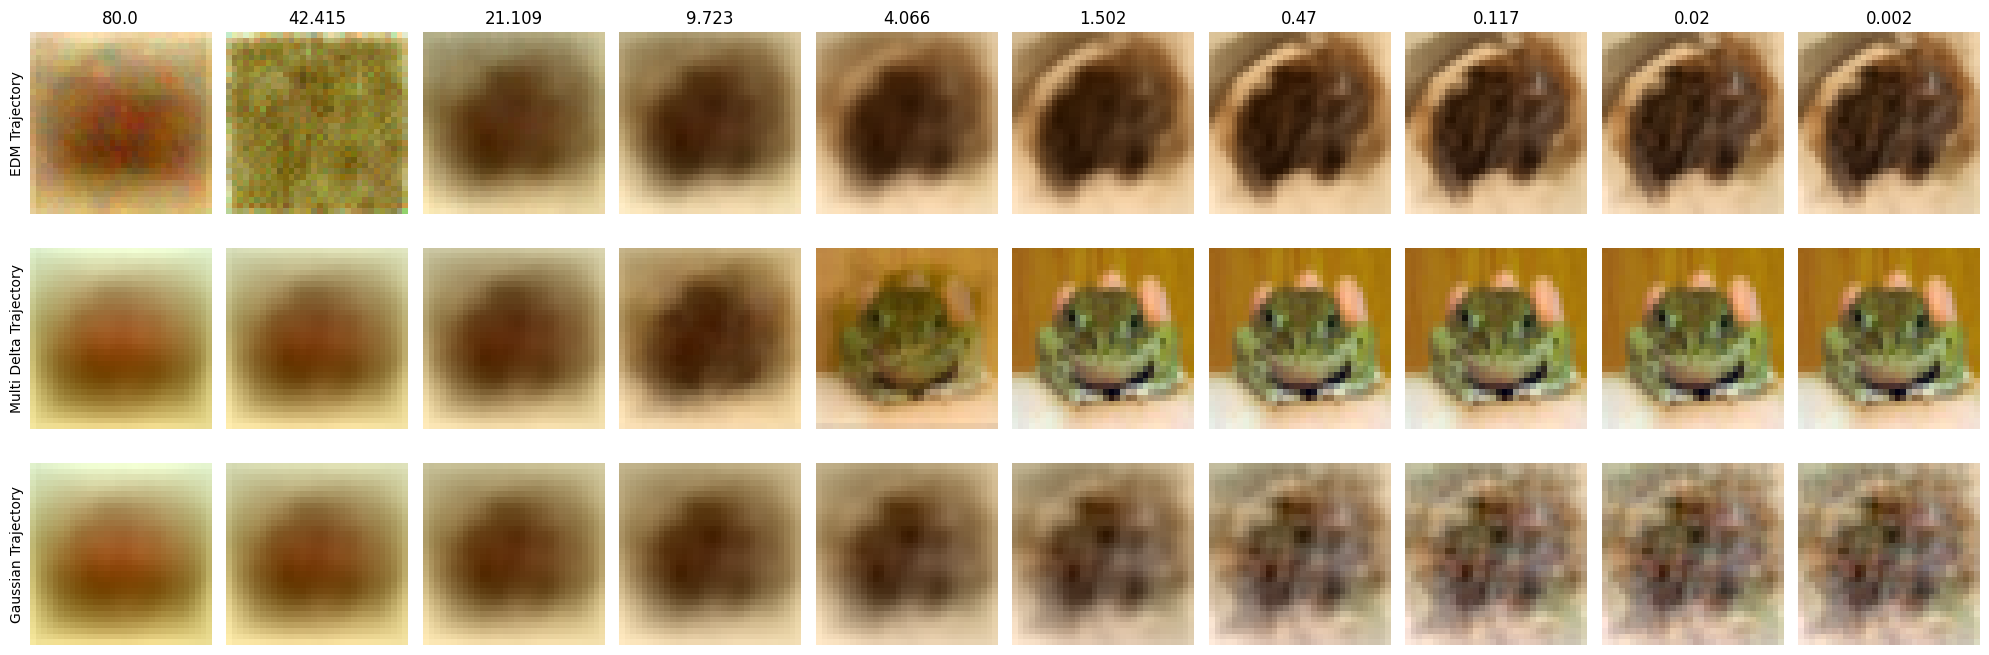

Sample idx: 7


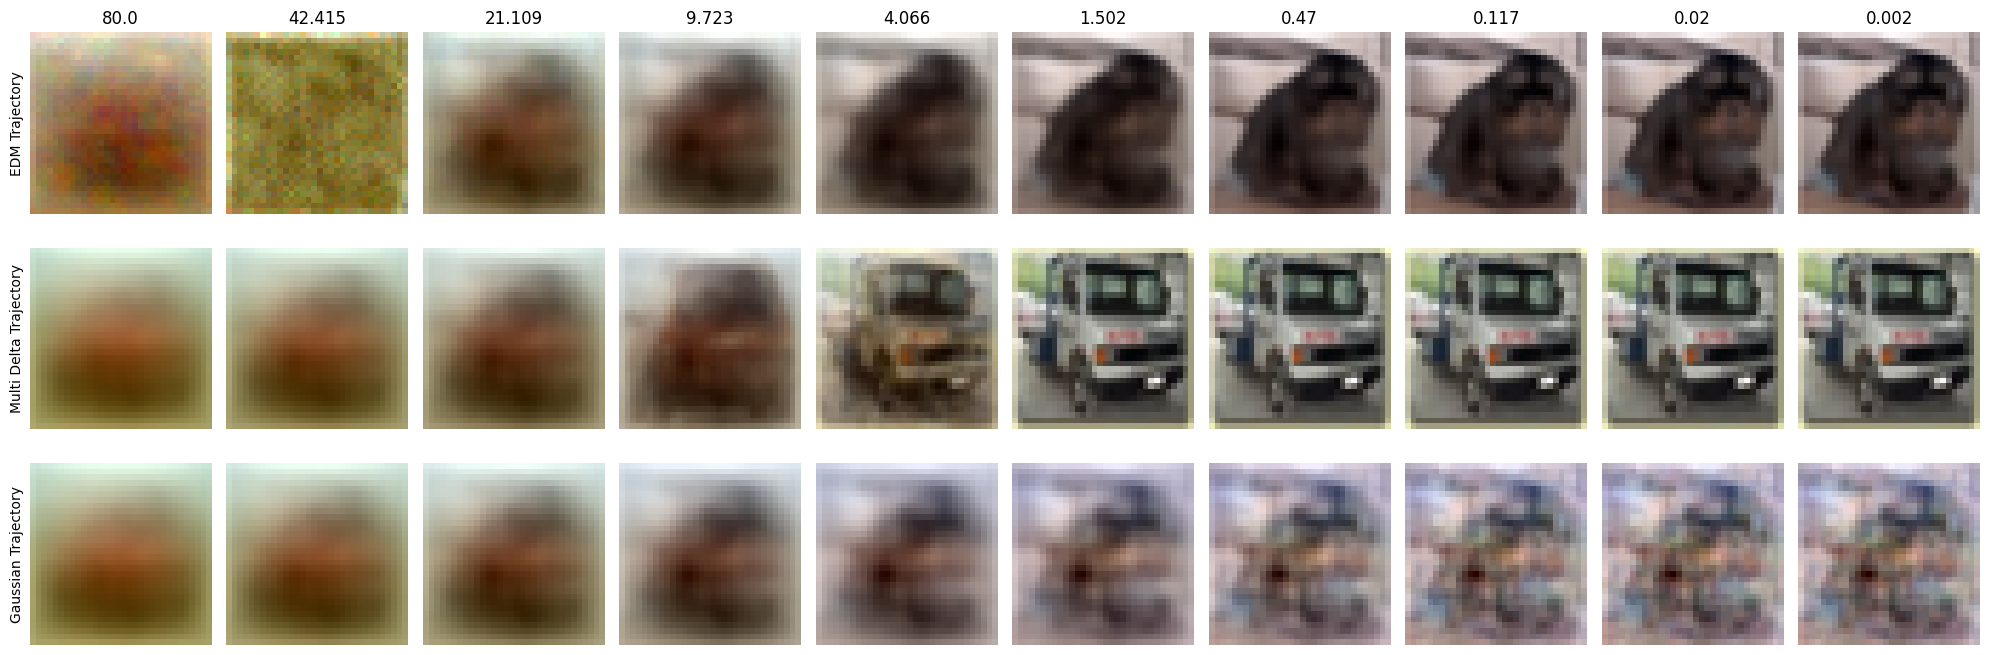

Sample idx: 8


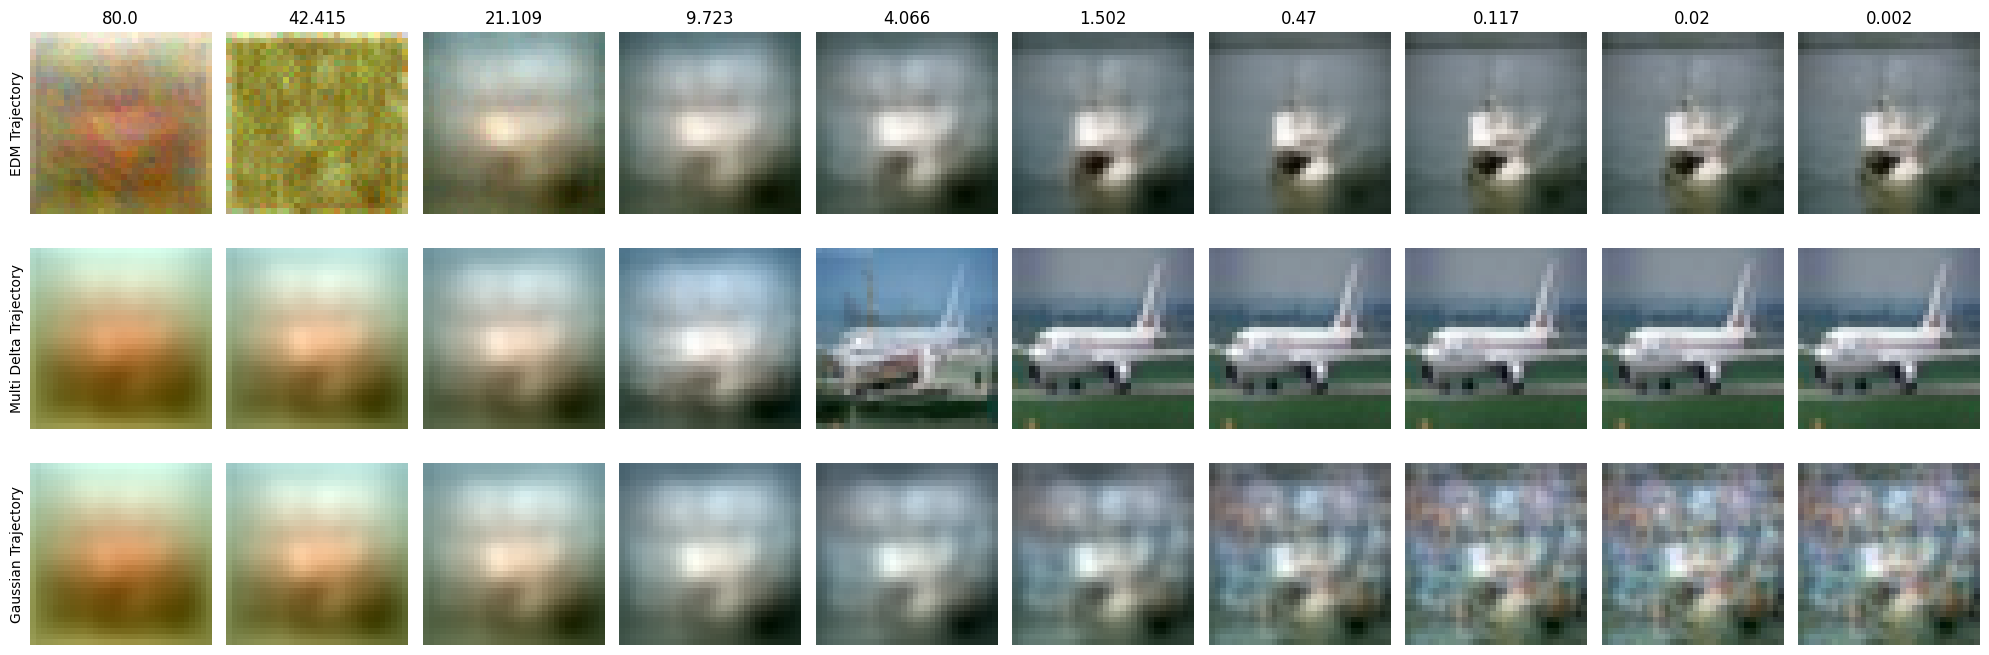

Sample idx: 9


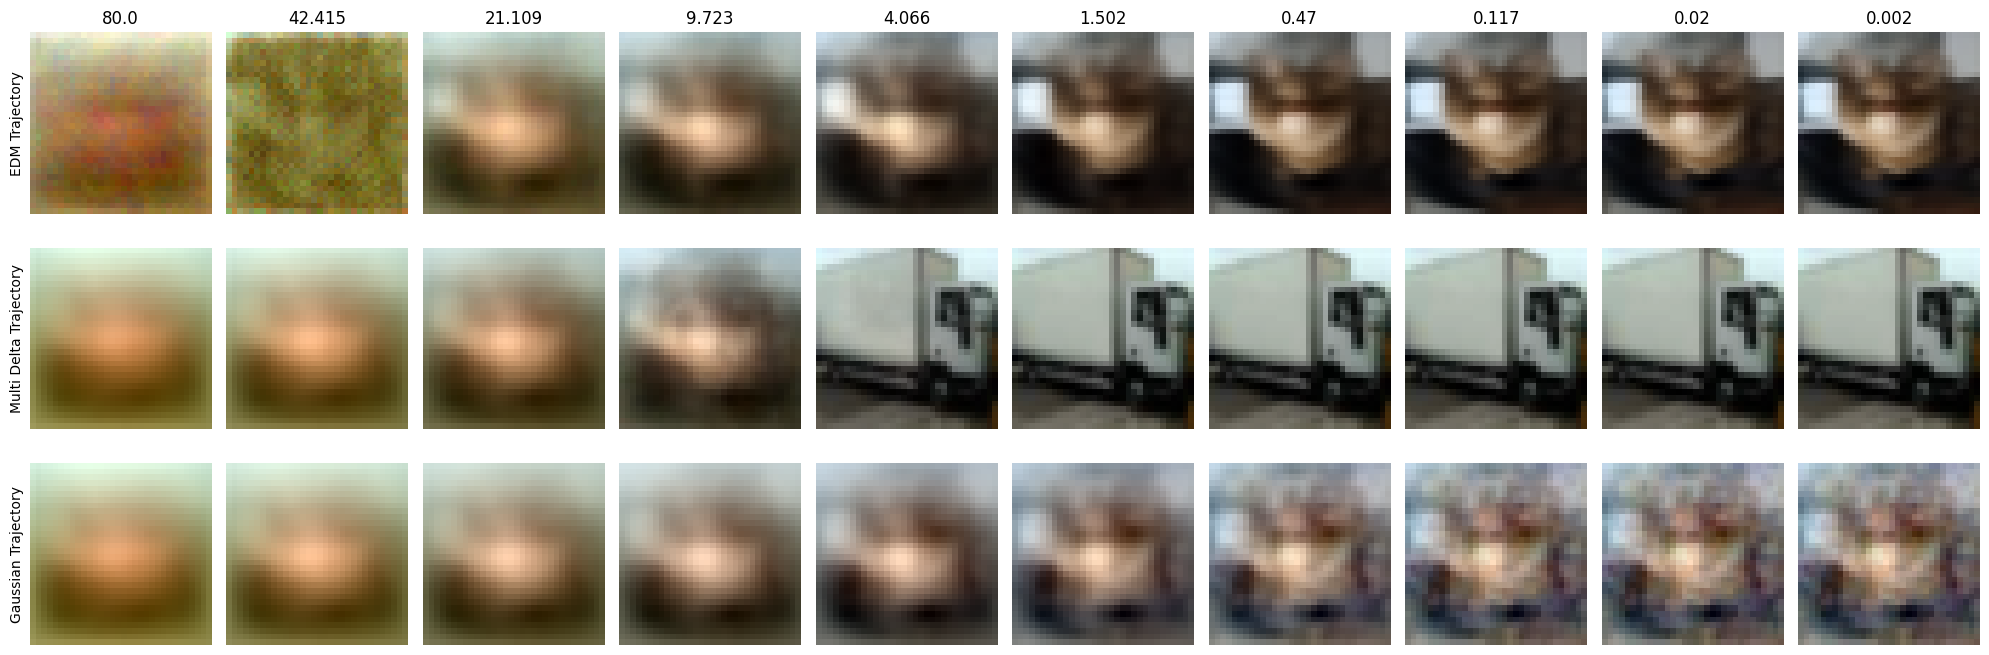

Sample idx: 10


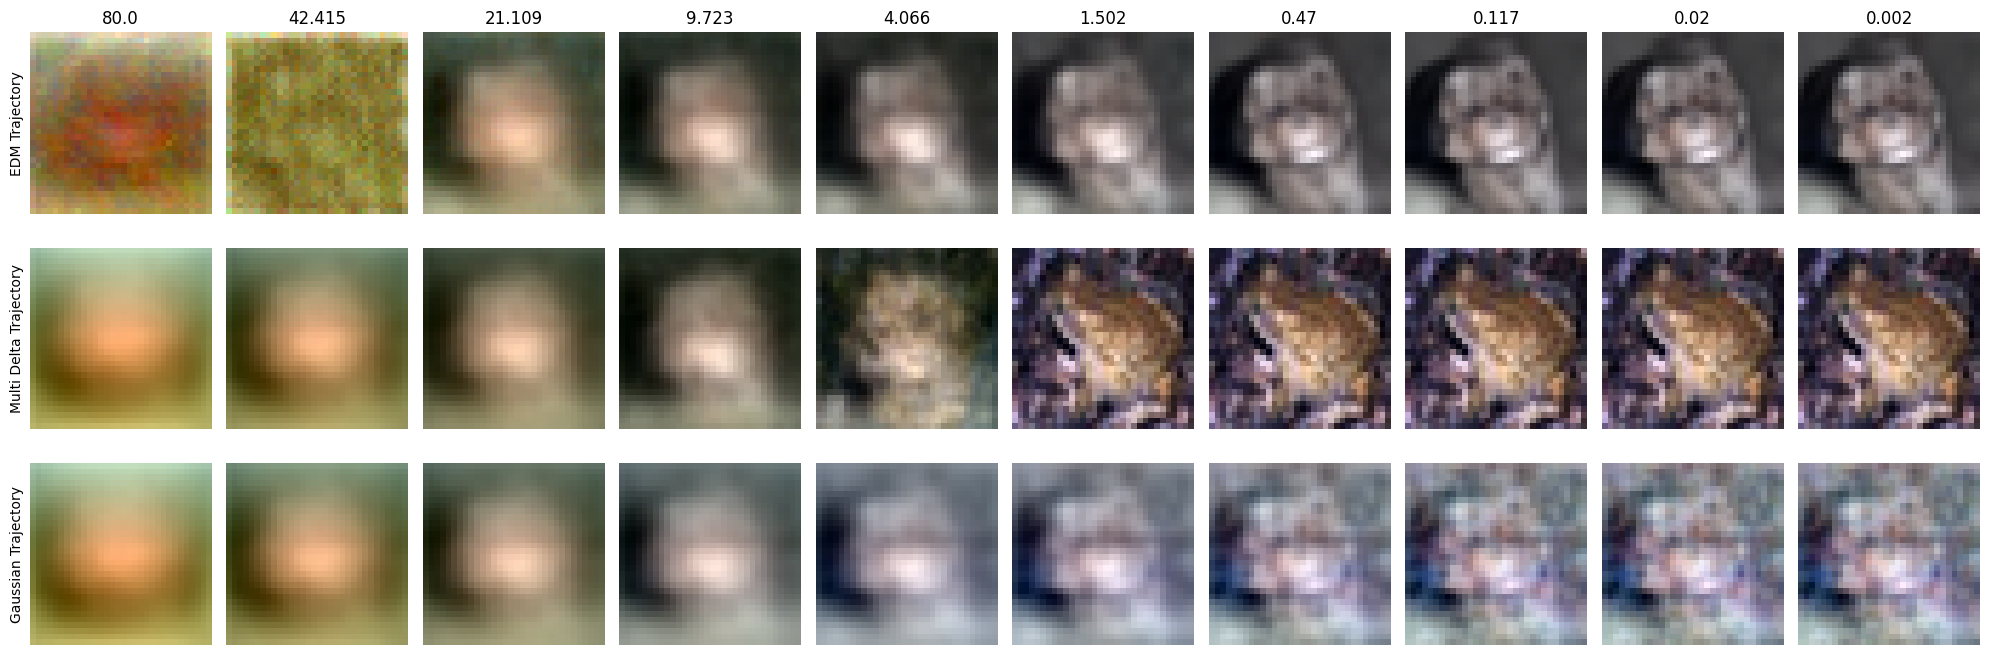

In [34]:
# Visualize the generation
for i in range(10):
    print('Sample idx: '+str(i+1))
    idx = i
    plt.figure(figsize=(20,9))
    plt.subplots_adjust(wspace=0,hspace=0)
    for i in range(10):
        plt.subplot(4,10,i+1)
        plt.title(round(sigma_list[i],3))
        plt.imshow(normalize_img(denoised_intermediates_edm[i][idx].permute(1,2,0)))
        if i==0:
            plt.ylabel('EDM Trajectory')
        plt.xticks([])
        plt.yticks([])
        for pos in ['right', 'top', 'bottom', 'left']: 
            plt.gca().spines[pos].set_visible(False) 
    for i in range(10):
        plt.subplot(4,10,i+1+10)
        #plt.title(round(sigma_list[i],3))
        plt.imshow(normalize_img(denoised_intermediates_optimal[i][idx].permute(1,2,0)))
        if i==0:
            plt.ylabel('Multi Delta Trajectory')
        plt.xticks([])
        plt.yticks([])
        for pos in ['right', 'top', 'bottom', 'left']: 
            plt.gca().spines[pos].set_visible(False) 
    for i in range(10):
        plt.subplot(4,10,i+1+20)
        #plt.title(round(sigma_list[i],3))
        plt.imshow(normalize_img(denoised_intermediates_Gaussian[i][idx].reshape(3,32,32).permute(1,2,0)))
        if i==0:
            plt.ylabel('Gaussian Trajectory')
        plt.xticks([])
        plt.yticks([])
        for pos in ['right', 'top', 'bottom', 'left']: 
            plt.gca().spines[pos].set_visible(False) 

    # Here we do not provide generations of the linear models since these models are quite large for storing and we want to make 
    # this notebook as easy to use as possible. We will include instructions for constructing the linear models in a seperate notebook.
    '''
    for i in range(10):
        plt.subplot(4,10,i+1+30)
        #plt.title(round(sigma_list[i],3))
        plt.imshow(normalize_img(denoised_intermediates_linear[i][idx].reshape(3,64,64).permute(1,2,0)))
        if i==0:
            plt.ylabel('Linear Model Trajectory')
        plt.xticks([])
        plt.yticks([])
        for pos in ['right', 'top', 'bottom', 'left']: 
            plt.gca().spines[pos].set_visible(False) 
    '''

    plt.tight_layout()
    plt.show()

### Here we do 10-step sampling and we see from the results above the Gaussian generations match the EDM generation (at least in terms of low frequency information). The difference between the generations will be larger if more steps are used since the difference will accumulate in each step. Below we visualize more samples.

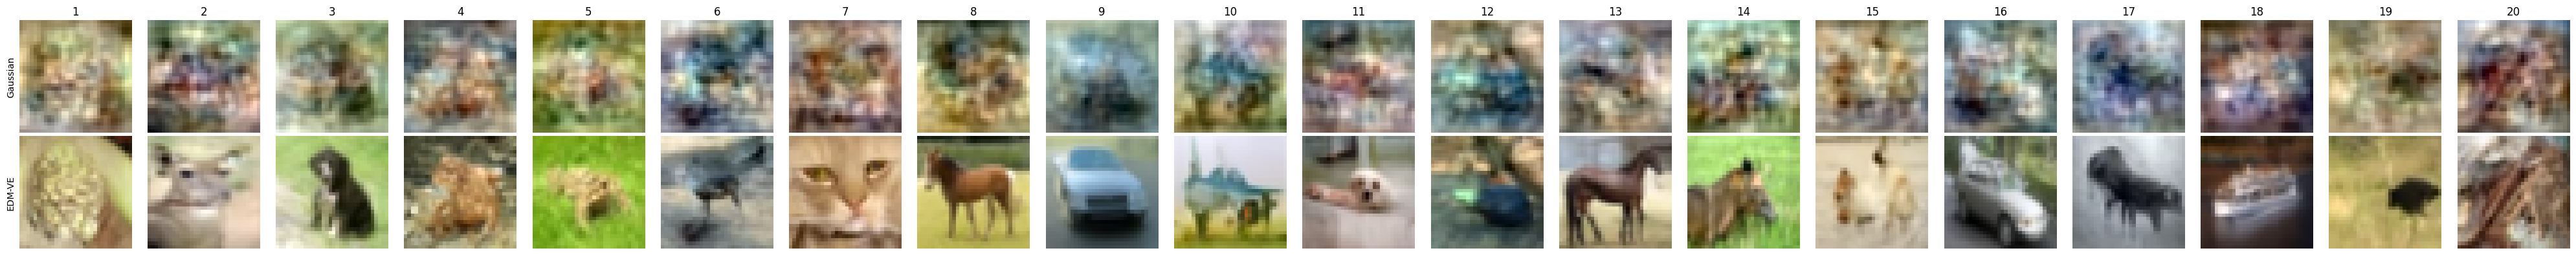

In [50]:
plt.figure(figsize=(40,4))
num_show = 20
idx_list = range(10,30)
for i in range(num_show):
    idx = idx_list[i]
    plt.subplot(2,num_show,i+1)
    plt.imshow(normalize_img(denoised_intermediates_Gaussian[-1][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('Gaussian')
    plt.title(str(i+1))
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
for i in range(num_show):
    idx = idx_list[i]
    plt.subplot(2,num_show,i+1+num_show)
    plt.imshow(normalize_img(denoised_intermediates_edm[-1][idx].reshape(3,32,32).cpu().permute(1,2,0)))
    if i==0:
        plt.ylabel('EDM-VE')
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
plt.tight_layout()